In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier

# 1. Load Data
bracket_train = pd.read_csv("bracket_training_cleaned.csv")
institutions = pd.read_csv("CCAC 2025 - Institutions_cleaned.csv")

# 2. Extract Team Performance Data from Institutions Data
inst_perf = institutions[[
    "InstitutionID", 
    "RegularSeasonAverageAttendance", 
    "RegularSeasonAverageScore", 
    "Win_Percentage", 
    "NCAA_Tenure"
]].copy()

# 3. Merge Team Performance Data into 'bracket_train'
regions = ["East", "West", "South", "Midwest"]
for region in regions:
    region_col = f"RegionWinner_{region}"
    inst_temp = inst_perf.copy()
    inst_temp.rename(columns={
    "InstitutionID": region_col,
    "RegularSeasonAverageAttendance": f"{region}_RegularSeasonAverageAttendance",
    "RegularSeasonAverageScore": f"{region}_RegularSeasonAverageScore",
    "Win_Percentage": f"{region}_Win_Percentage",
    "NCAA_Tenure": f"{region}_NCAA_Tenure"
    }, inplace=True)
    bracket_train = bracket_train.merge(inst_temp, on=region_col, how="left")

# 4. Set Features
base_features = [
    "CustomerID",
    "CustomerDMACode",
    "BracketEntryId",
    "RegionWinner_East",
    "RegionWinner_West",
    "RegionWinner_South",
    "RegionWinner_Midwest",
    "NCAACustomerRecordCreated_Year",
    "NCAACustomerRecordCreated_Month",
    "BracketEntryCreatedDate_Year",
    "BracketEntryCreatedDate_Month"
]
perf_features = []
for region in regions:
    perf_features.extend([f"{region}_RegularSeasonAverageAttendance", f"{region}_RegularSeasonAverageScore", f"{region}_Win_Percentage", f"{region}_NCAA_Tenure"])

features = base_features + perf_features

In [3]:
targets = ["NationalChampion", "SemifinalWinner_East_West", "SemifinalWinner_South_Midwest"]
label_encoders = {}
for target in targets:
    le = LabelEncoder()
    bracket_train[target] = le.fit_transform(bracket_train[target])
    label_encoders[target] = le

bracket_train = bracket_train.fillna(0)

features_to_use = [col for col in features if col not in ["CustomerID", "BracketEntryId"]]

X = bracket_train[features_to_use]
y_nc = bracket_train["NationalChampion"]
y_semi_ew = bracket_train["SemifinalWinner_East_West"]
y_semi_sm = bracket_train["SemifinalWinner_South_Midwest"]

X_train, X_val, y_train_nc, y_val_nc = train_test_split(X, y_nc, test_size=0.2, random_state=42)
_, _, y_train_semi_ew, y_val_semi_ew = train_test_split(X, y_semi_ew, test_size=0.2, random_state=42)
_, _, y_train_semi_sm, y_val_semi_sm = train_test_split(X, y_semi_sm, test_size=0.2, random_state=42)

model_nc = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
model_semi_ew = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
model_semi_sm = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)

model_nc.fit(X_train, y_train_nc)
model_semi_ew.fit(X_train, y_train_semi_ew)
model_semi_sm.fit(X_train, y_train_semi_sm)

y_pred_nc = model_nc.predict(X_val)
acc_nc = accuracy_score(y_val_nc, y_pred_nc)
print("Validation Accuracy - NationalChampion:", acc_nc)

Validation Accuracy - NationalChampion: 0.458507024857187


In [9]:
import pickle

with open("model_nc_team.pkl", "wb") as f:
    pickle.dump(xgb_nc, f)

with open("model_semi_ew_team.pkl", "wb") as f:
    pickle.dump(xgb_semi_ew, f)

with open("model_semi_sm_team.pkl", "wb") as f:
    pickle.dump(xgb_semi_sm, f)

/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_87684/1472198783.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="Blues_r")


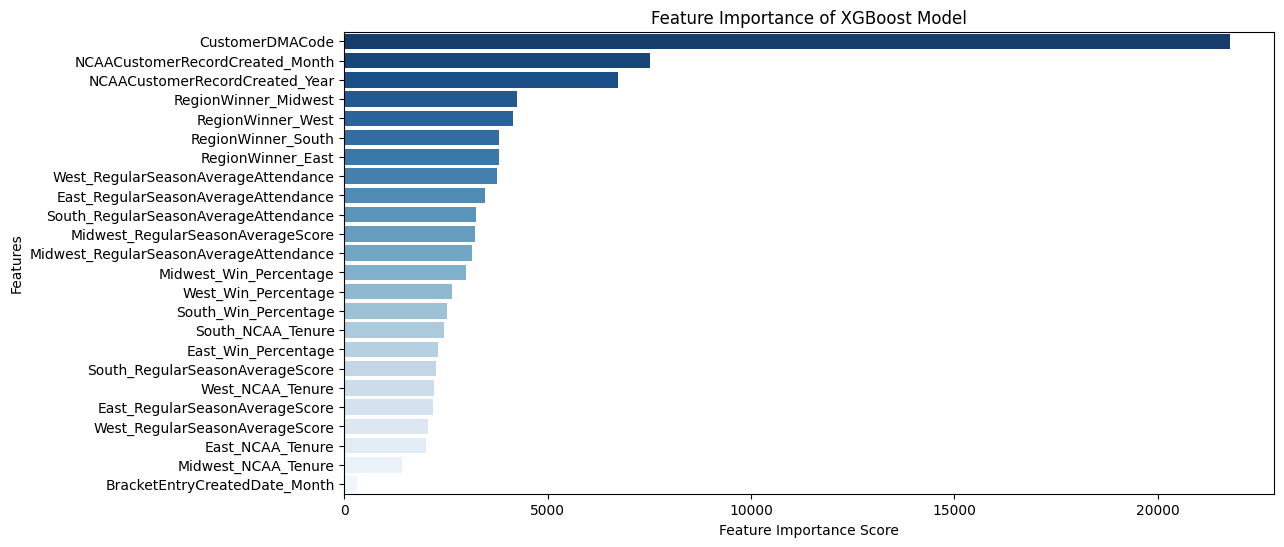

🔹 Feature Importance Results:
                                   Feature  Importance
0                          CustomerDMACode     21775.0
6          NCAACustomerRecordCreated_Month      7524.0
5           NCAACustomerRecordCreated_Year      6718.0
4                     RegionWinner_Midwest      4256.0
2                        RegionWinner_West      4150.0
3                       RegionWinner_South      3806.0
1                        RegionWinner_East      3792.0
12     West_RegularSeasonAverageAttendance      3761.0
8      East_RegularSeasonAverageAttendance      3459.0
16    South_RegularSeasonAverageAttendance      3231.0
21       Midwest_RegularSeasonAverageScore      3213.0
20  Midwest_RegularSeasonAverageAttendance      3143.0
22                  Midwest_Win_Percentage      3000.0
14                     West_Win_Percentage      2644.0
18                    South_Win_Percentage      2529.0
19                       South_NCAA_Tenure      2454.0
10                     East_Win_Per

In [33]:
feature_importance1 = model_nc.get_booster().get_score(importance_type="weight")
                                                       
importance_df = pd.DataFrame({"Feature": feature_importance1.keys(), "Importance": feature_importance1.values()})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="Blues_r")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance of XGBoost Model")
plt.show()

print("🔹 Feature Importance Results:")
print(importance_df)

/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_87684/1908786764.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df2, palette="Blues_r")


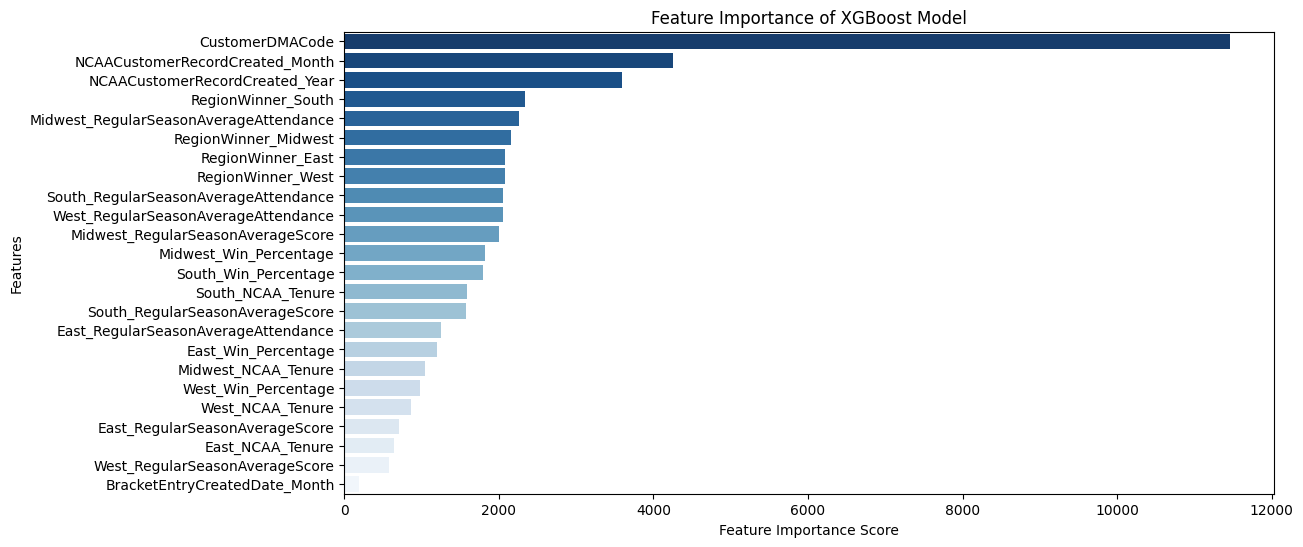

🔹 Feature Importance Results:
                                   Feature  Importance
0                          CustomerDMACode     11461.0
6          NCAACustomerRecordCreated_Month      4255.0
5           NCAACustomerRecordCreated_Year      3588.0
3                       RegionWinner_South      2333.0
20  Midwest_RegularSeasonAverageAttendance      2263.0
4                     RegionWinner_Midwest      2152.0
1                        RegionWinner_East      2076.0
2                        RegionWinner_West      2075.0
16    South_RegularSeasonAverageAttendance      2059.0
12     West_RegularSeasonAverageAttendance      2053.0
21       Midwest_RegularSeasonAverageScore      2001.0
22                  Midwest_Win_Percentage      1817.0
18                    South_Win_Percentage      1795.0
19                       South_NCAA_Tenure      1586.0
17         South_RegularSeasonAverageScore      1577.0
8      East_RegularSeasonAverageAttendance      1256.0
10                     East_Win_Per

In [35]:
feature_importance2 = model_semi_ew.get_booster().get_score(importance_type="weight")
importance_df2 = pd.DataFrame({"Feature": feature_importance2.keys(), "Importance": feature_importance2.values()})
importance_df2 = importance_df2.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x="Importance", y="Feature", data=importance_df2, palette="Blues_r")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance of XGBoost Model")
plt.show()

print("🔹 Feature Importance Results:")
print(importance_df2)

/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_87684/4285722655.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df3, palette="Blues_r")


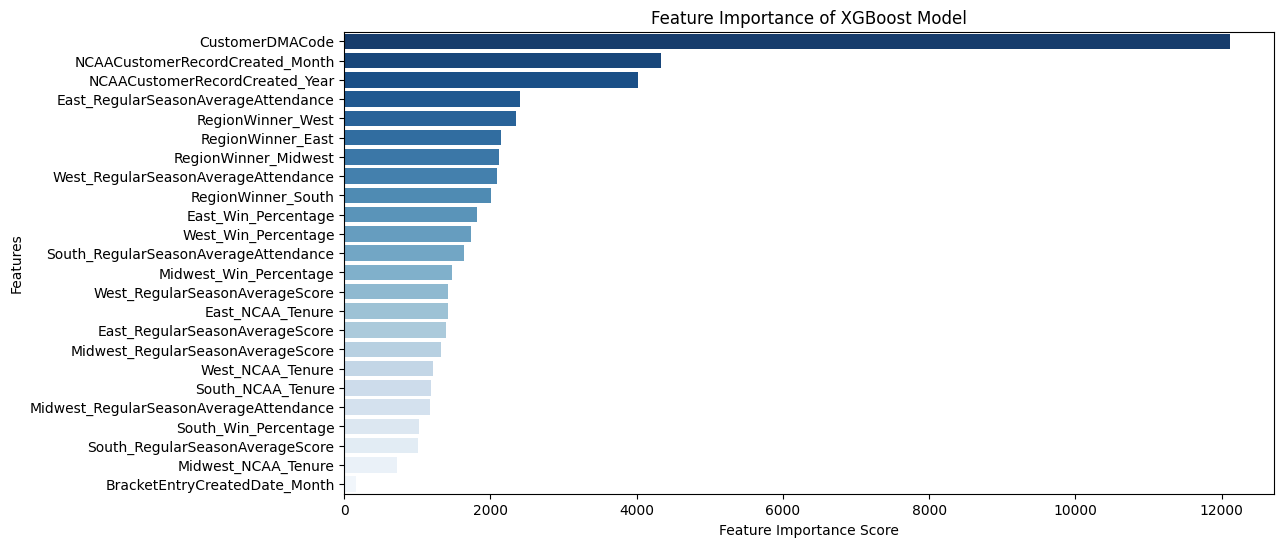

🔹 Feature Importance Results:
                                   Feature  Importance
0                          CustomerDMACode     12115.0
6          NCAACustomerRecordCreated_Month      4326.0
5           NCAACustomerRecordCreated_Year      4018.0
8      East_RegularSeasonAverageAttendance      2407.0
2                        RegionWinner_West      2348.0
1                        RegionWinner_East      2137.0
4                     RegionWinner_Midwest      2118.0
12     West_RegularSeasonAverageAttendance      2085.0
3                       RegionWinner_South      2012.0
10                     East_Win_Percentage      1816.0
14                     West_Win_Percentage      1728.0
16    South_RegularSeasonAverageAttendance      1640.0
22                  Midwest_Win_Percentage      1472.0
13          West_RegularSeasonAverageScore      1414.0
11                        East_NCAA_Tenure      1412.0
9           East_RegularSeasonAverageScore      1393.0
21       Midwest_RegularSeasonAvera

In [37]:
feature_importance3 = model_semi_sm.get_booster().get_score(importance_type="weight")
importance_df3 = pd.DataFrame({"Feature": feature_importance3.keys(), "Importance": feature_importance3.values()})
importance_df3 = importance_df3.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x="Importance", y="Feature", data=importance_df3, palette="Blues_r")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance of XGBoost Model")
plt.show()

print("🔹 Feature Importance Results:")
print(importance_df3)